# Bivariate analysis


The objective of this notebook is to analyze each variable vs. the target to understand patterns, associations, and potential causal relationships between the variables.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import scatter_plot
import numpy as np
import category_encoders as ce
import os

if not os.path.exists('images_bivar_analysis'):
    os.makedirs('images_bivar_analysis')

In [17]:
data = pd.read_parquet('../data/processed/df_fraud_univar.parquet', engine= 'fastparquet')
data.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.639648,C1231006815,170136.0,160296.359375,M1979787155,0.0,0.0,no_fraud
1,1,PAYMENT,1864.280029,C1666544295,21249.0,19384.720703,M2044282225,0.0,0.0,no_fraud
2,1,TRANSFER,181.000000,C1305486145,181.0,0.000000,C553264065,0.0,0.0,fraud
3,1,CASH_OUT,181.000000,C840083671,181.0,0.000000,C38997010,21182.0,0.0,fraud
4,1,PAYMENT,11668.139648,C2048537720,41554.0,29885.859375,M1230701703,0.0,0.0,no_fraud


## step & day_of_month vs. isFraud

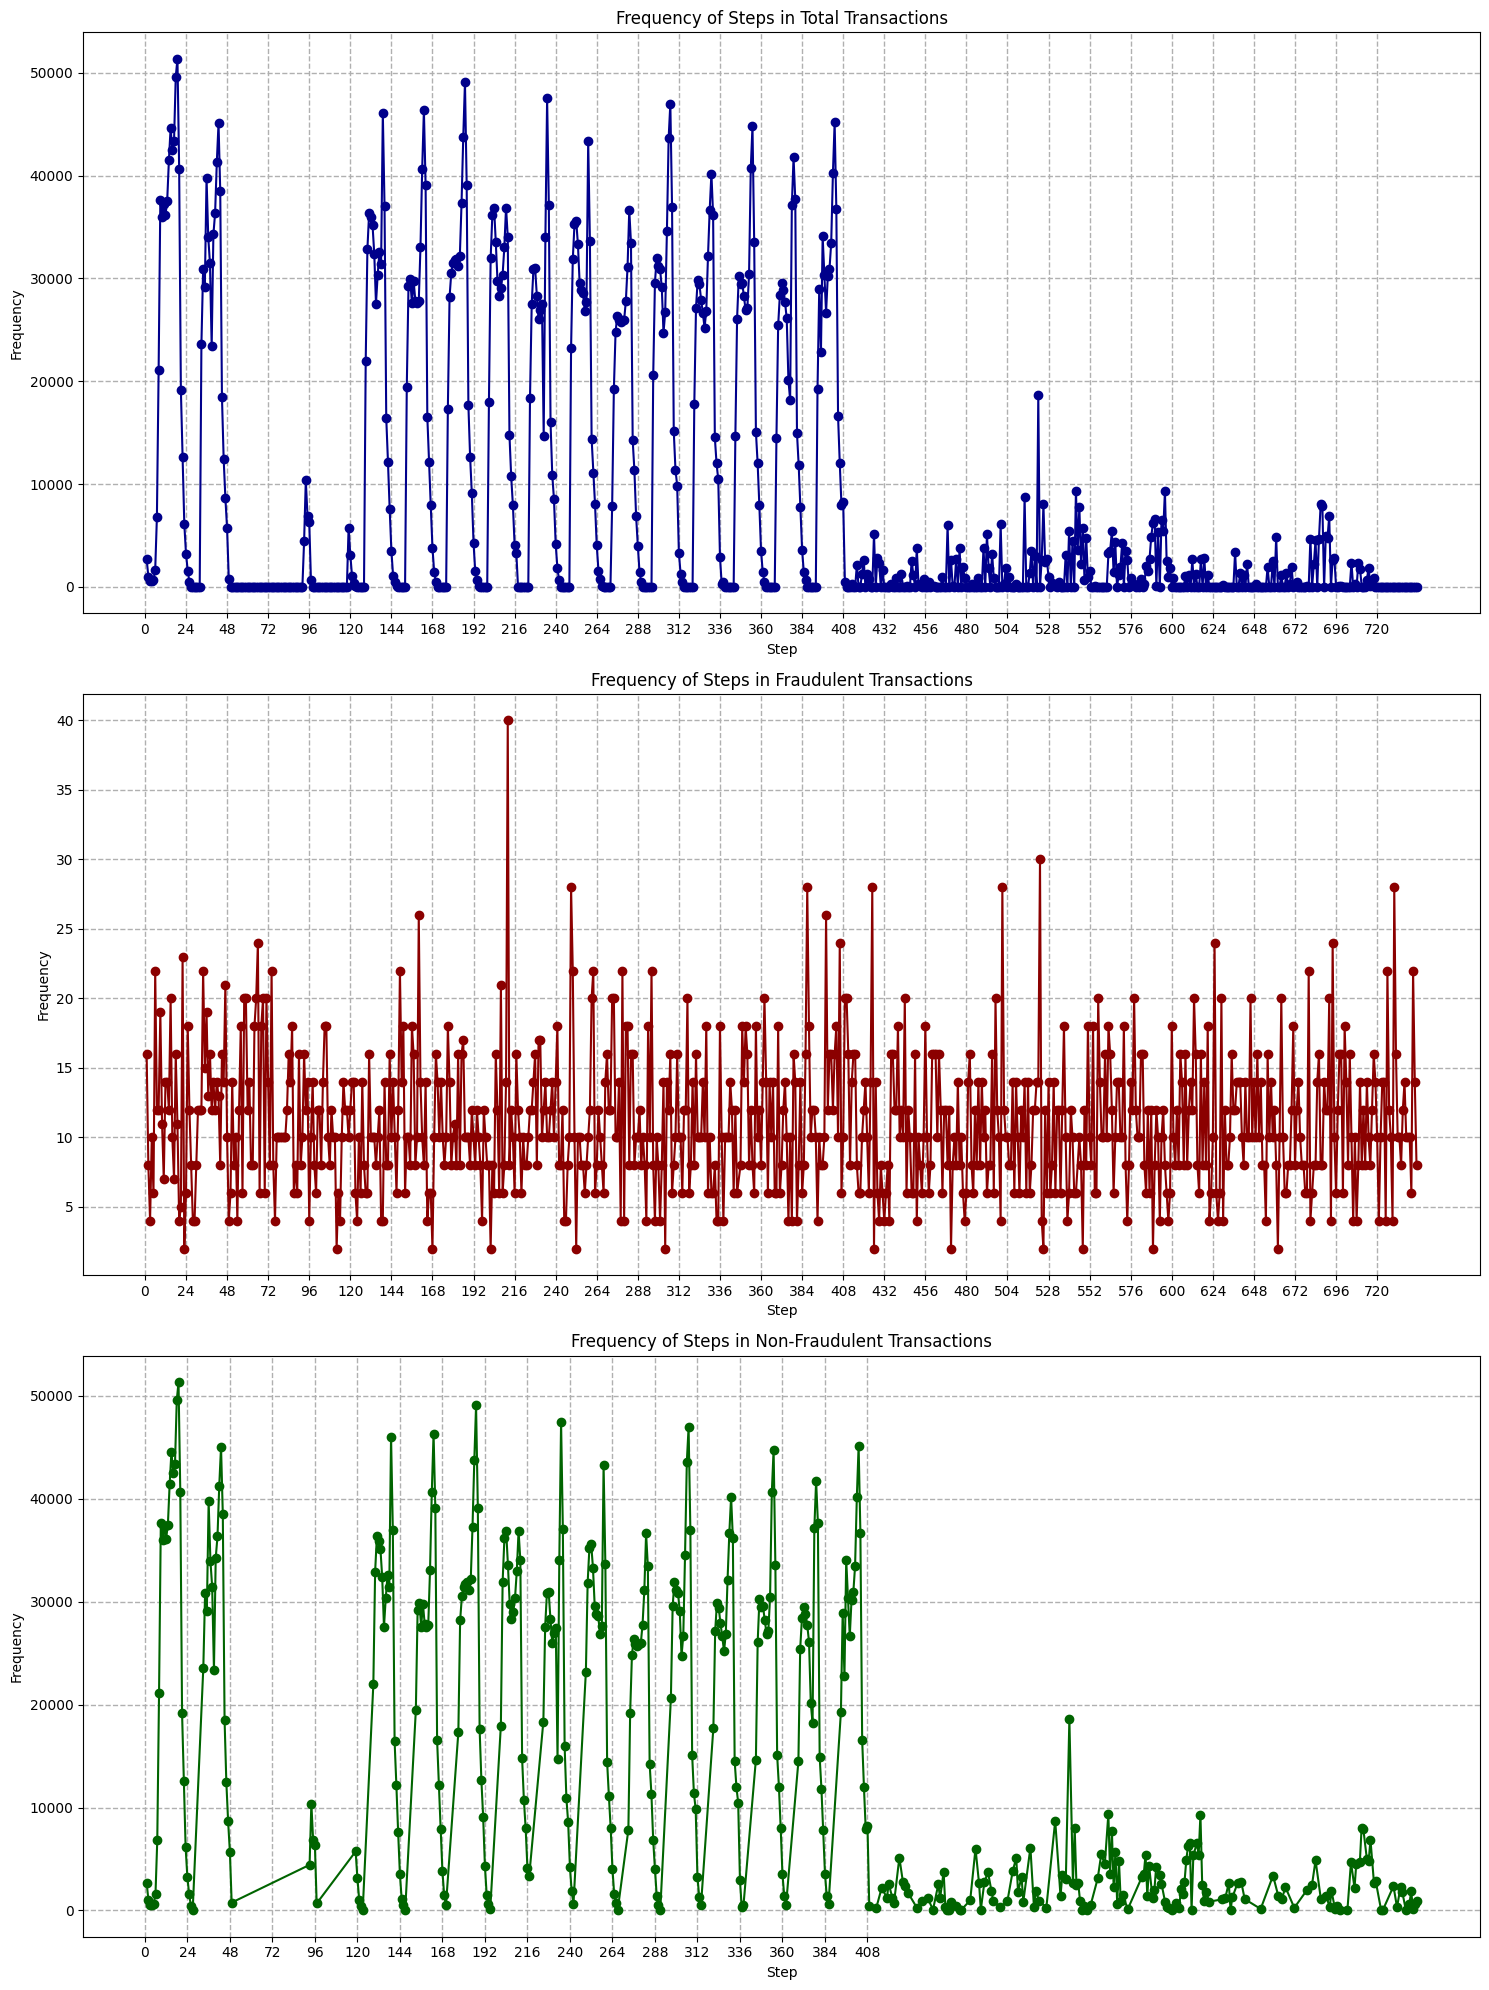

In [3]:
total_value_counts = data['step'].value_counts().sort_index()
fraud_value_counts = data[data['isFraud'] == 1]['step'].value_counts().sort_index()
non_fraud_value_counts = data[data['isFraud'] == 0]['step'].value_counts().sort_index()

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 20))

for ax, counts, title, color in zip(axes, [total_value_counts, fraud_value_counts, non_fraud_value_counts], 
                                    ["Frequency of Steps in Total Transactions", 
                                     "Frequency of Steps in Fraudulent Transactions", 
                                     "Frequency of Steps in Non-Fraudulent Transactions"], 
                                    ['#00008B', '#8B0000', '#006400']):
    ax.plot(counts.index, counts, marker='o', color=color)
    ax.set_title(title)
    ax.set_xlabel("Step")
    ax.set_ylabel("Frequency")
    ax.grid(which='both', linestyle='--', linewidth=1)
    ax.set_xticks(np.arange(0, len(counts) + 1, 24)) 
    
plt.tight_layout()
plt.show()

Observations:

For context, 1 step represents 1 hour. The total range of hour data is equivalent to a month. 

There is a clear pattern that differentiates the behaviour between the fraudulent and the non-fraudulent transactions. 

Non-fraudulent transactions happen inside defined step ranges and slow down when the step is a bit higher than 400 (15 days aprox). This behaviour makes sense since people get their salaries at the beginning of the month. The is a gap between the first 48 and 120 hours. It would be interesting to get more information about the month, year, country from where the transaction was sent/received. Was it a public holiday? 

Fraudulent transactions stay constant along the step range. That means fraudsters behaviour stays constant all over the month. 

Fraudsters usually take very short time to process the transaction so it would be also nice to obtain data about the amount of time spent on the merchants website, the time used by the client to confirm the transaction (short times can indicate that a bot is actually using the platform), etc.

In [4]:
contingency_table = pd.crosstab(data['day_of_month'], data['isFraud'])
contingency_table

isFraud,0,1
day_of_month,,
1.0,573984,271
2.0,454929,309
3.0,760,310
4.0,27978,262
5.0,9537,252
6.0,440777,228
7.0,420311,272
8.0,449359,278
9.0,417664,255


/tmp/ipykernel_22182/2534009943.py:9: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(x='day_of_month', y='proportion', hue='isFraud', data=df_grouped, palette=palette)


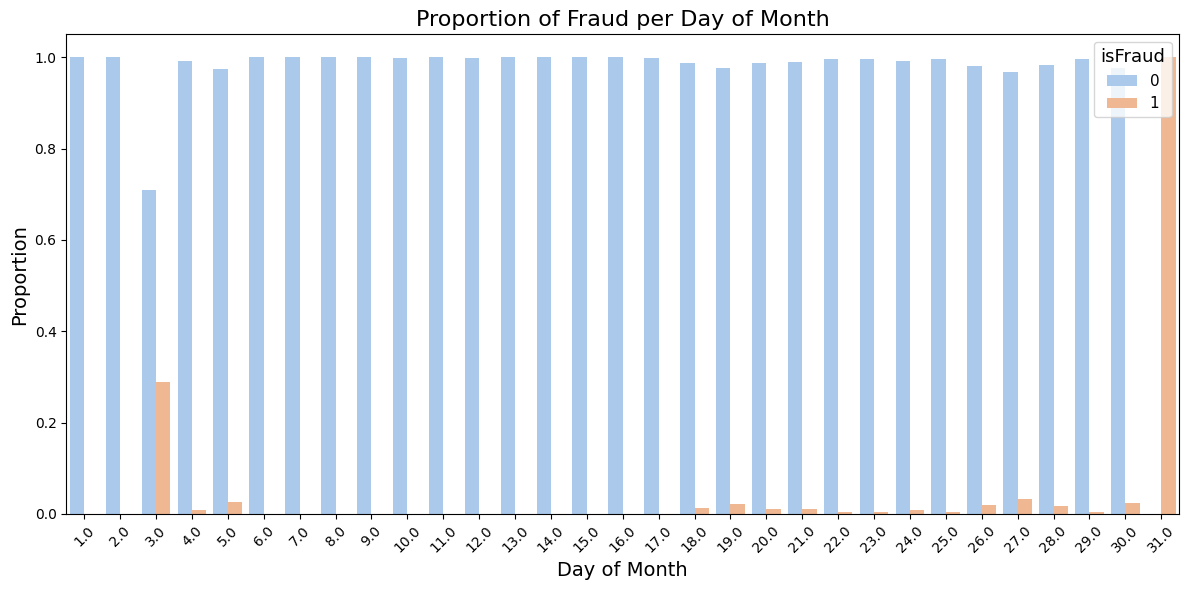

In [5]:

df_grouped = data.groupby(['day_of_month', 'isFraud']).size().reset_index(name='count')



df_grouped['proportion'] = df_grouped.groupby('day_of_month')['count'].transform(lambda x: x / x.sum())

plt.figure(figsize=(12, 6))
palette = sns.color_palette("pastel") 
sns.barplot(x='day_of_month', y='proportion', hue='isFraud', data=df_grouped, palette=palette)

plt.title('Proportion of Fraud per Day of Month', fontsize=16)
plt.xlabel('Day of Month', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.xticks(rotation=45)  
plt.legend(title='isFraud', title_fontsize='13', fontsize='11')
plt.tight_layout()  
plt.show()

Observations:

- The last day of the month has only fraudulent transactions. Curious, right? I would need more info about the context but it looks like it's a coincidence.

Besides that I don't see any clear pattern.

## type vs. isFraud

In [6]:
data.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrig    float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
day_of_month      float64
amount_range       object
dtype: object

In [7]:
contingency_table = pd.crosstab(data['type'], data['isFraud'])
contingency_table

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


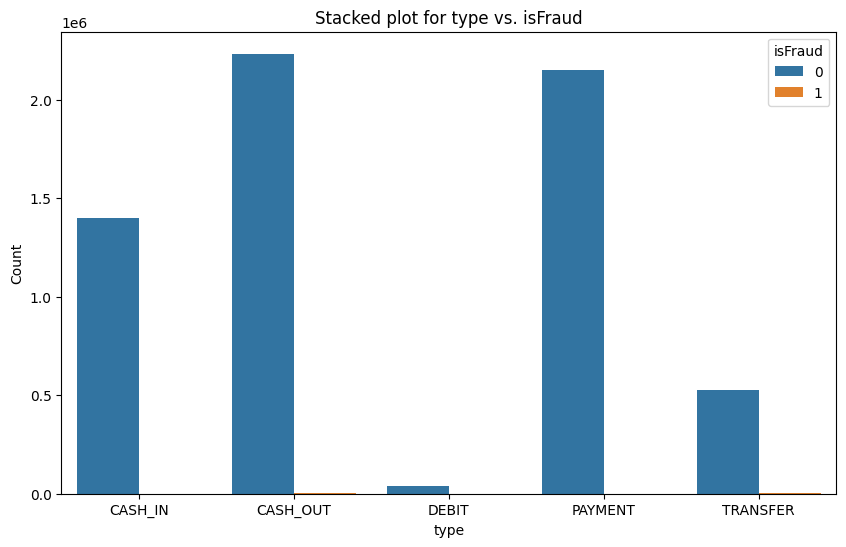

In [8]:
plt.figure(figsize=(10, 6))
df_grouped = data.groupby(['type', 'isFraud']).size().reset_index(name='count')
sns.barplot(x='type', y='count', hue='isFraud', data=df_grouped)

plt.title('Stacked plot for type vs. isFraud')
plt.xlabel('type')
plt.ylabel('Count')
plt.show()

Observations:

The only types that have fraudulent transactions are CASH_OUT and TRANSFER and as we saw in the univariate analysis they are substantially less common

-------

## amount vs. isFraud

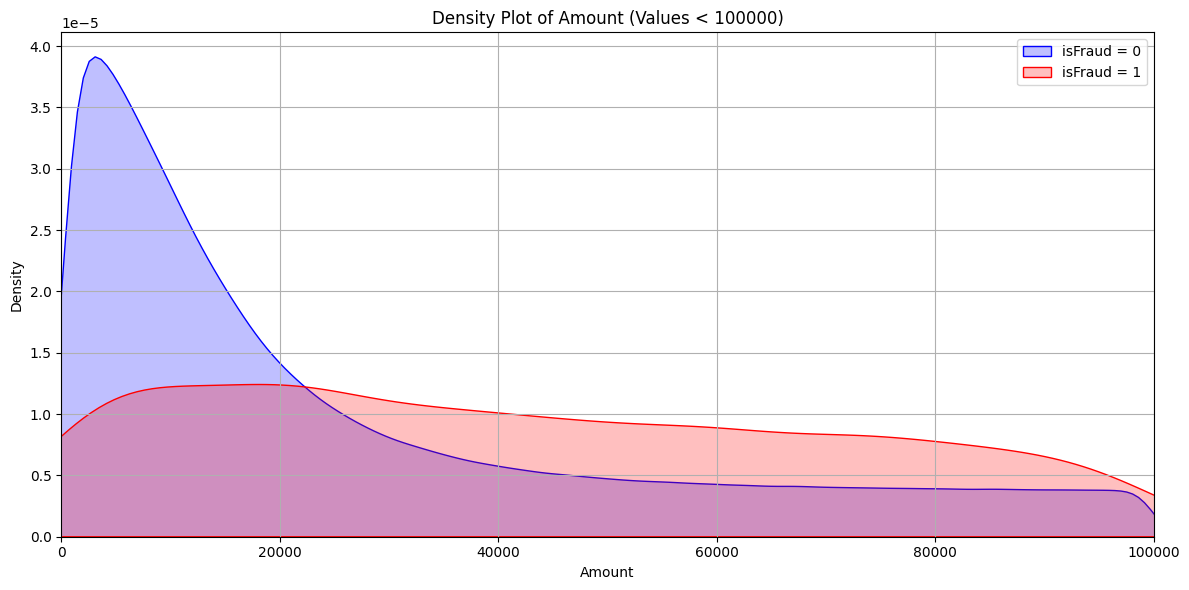

In [9]:
data_filtered1 = data[data['amount'] < 100000]
data_filtered2 = data[(data['amount'] >= 100000) & (data['amount'] < 10000000)]
data_filtered3 = data[data['amount'] >= 10000000]


def plot_density(data, title, xlim):
    plt.figure(figsize=(12, 6))
    sns.kdeplot(data[data['isFraud'] == 0]['amount'], fill=True, label='isFraud = 0', color='blue')
    sns.kdeplot(data[data['isFraud'] == 1]['amount'], fill=True, label='isFraud = 1', color='red')
    plt.title(title)
    plt.xlabel('Amount')
    plt.ylabel('Density')
    plt.legend()
    plt.xlim(xlim)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

plot_density(data_filtered1, 'Density Plot of Amount (Values < 100000)', (0, 100000))
# plot_density(data_filtered2, 'Density Plot of Amount (100000 <= Values < 10000000)', (100000, 10000000))
# plot_density(data_filtered3, 'Density Plot of Amount (Values >= 10000000)', (10000000, data['amount'].max()))


Observations:

What we see in these density plots is the distribution of the transactions divided by fraud. Peaks in the density plot indicate the most common transaction amounts within the range. The spread (width) of the density plot indicates the variability in transaction amounts.

- Plot 1: transactions with amounts lower than 20.000 tend to be much likely to be non fraudulent

In [10]:
data.query('amount == 0')

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range
2736447,212,CASH_OUT,0.0,C1510987794,0.0,0.0,C1696624817,0.00,0.00,1,9.0,0-1.000
3247298,250,CASH_OUT,0.0,C521393327,0.0,0.0,C480398193,0.00,0.00,1,11.0,0-1.000
3760289,279,CASH_OUT,0.0,C539112012,0.0,0.0,C1106468520,538547.63,538547.63,1,12.0,0-1.000
5563714,387,CASH_OUT,0.0,C1294472700,0.0,0.0,C1325541393,7970766.57,7970766.57,1,17.0,0-1.000
5996408,425,CASH_OUT,0.0,C832555372,0.0,0.0,C1462759334,76759.90,76759.90,1,18.0,0-1.000
5996410,425,CASH_OUT,0.0,C69493310,0.0,0.0,C719711728,2921531.34,2921531.34,1,18.0,0-1.000
6168500,554,CASH_OUT,0.0,C10965156,0.0,0.0,C1493336195,230289.66,230289.66,1,24.0,0-1.000
6205440,586,CASH_OUT,0.0,C1303719003,0.0,0.0,C900608348,1328472.86,1328472.86,1,25.0,0-1.000
6266414,617,CASH_OUT,0.0,C1971175979,0.0,0.0,C1352345416,0.00,0.00,1,26.0,0-1.000
6281483,646,CASH_OUT,0.0,C2060908932,0.0,0.0,C1587892888,0.00,0.00,1,27.0,0-1.000


Observations: 

All transactions with amount = 0 are fraudulent

----



In [11]:
repeated_rows = data[data.duplicated('amount', keep=False) & (data['amount'] != 0)]

repeated_amounts = (repeated_rows.groupby('amount')
                    .agg(count_isFraud_0=('isFraud', lambda x: (x == 0).sum()),
                         count_isFraud_1=('isFraud', lambda x: (x == 1).sum()),
                         percentage_isFraud_0=('isFraud', lambda x: round((x == 0).mean() * 100, 2)),
                         percentage_isFraud_1=('isFraud', lambda x: round((x == 1).mean() * 100, 2)))
                    .reset_index())

KeyboardInterrupt: 

In [ ]:
repeated_rows

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,1.0,1.000-10.000
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,1.0,1.000-10.000
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,1.0,0-1.000
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,1.0,0-1.000
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.00,0.00,0,1.0,1.000-10.000
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,31.0,100.000-1.000.000
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,31.0,1.000.000-10.000.000
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,31.0,1.000.000-10.000.000
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,31.0,100.000-1.000.000


In [ ]:
repeated_amounts

,amount,count_isFraud_0,count_isFraud_1,percentage_isFraud_0,percentage_isFraud_1
0,0.02,3,0,100.00,0.00
1,0.03,2,0,100.00,0.00
2,0.11,2,0,100.00,0.00
3,0.14,2,0,100.00,0.00
4,0.18,2,0,100.00,0.00
...,...,...,...,...,...
778470,9887819.06,0,2,0.00,100.00
778471,9960382.40,0,2,0.00,100.00
778472,9977761.05,0,2,0.00,100.00
778473,9996886.64,0,2,0.00,100.00


In [ ]:
%store repeated_amounts

Stored 'repeated_amounts' (DataFrame)


In [ ]:
%store -r repeated_amounts


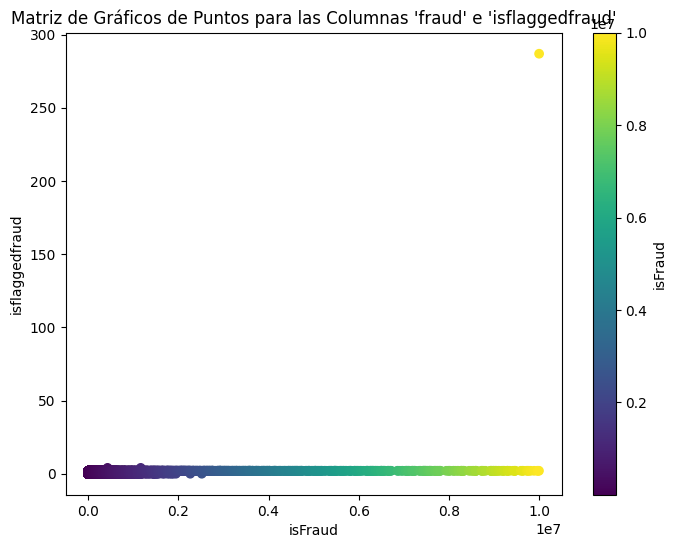

In [ ]:
scatter_plot(repeated_amounts['amount'], repeated_amounts['count_isFraud_1'])

In [ ]:
integer_rows = data[data['amount'] == data['amount'].astype(int)]

# Agrupar por 'amount' y calcular los porcentajes de 'isFraud'
integer_amounts = integer_rows.groupby('amount').apply(lambda x: pd.Series({
    'count': x.shape[0],
    'percentage_isFraud_0': (x['isFraud'] == 0).mean() * 100,
    'percentage_isFraud_1': (x['isFraud'] == 1).mean() * 100
})).reset_index()

## nameOrig vs. isFraud

From the univariate analysis we found that there were many transactions with the same amount. Let's check them

## oldbalanceOrig vs. isFraud

## newbalanceOrig vs. isFraud

---

### Correlation

In [18]:
numerical_cols = data.select_dtypes(include=['float32', 'int16']).columns
categorical_cols = data.select_dtypes(include=['object', 'category']).columns
numerical_cols


Index(['step', 'amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')

In [19]:
if numerical_cols.empty:
    raise ValueError("No se encontraron columnas numéricas en el dataset.")
if categorical_cols.empty:
    raise ValueError("No se encontraron columnas categóricas en el dataset.")

# Aplicar Target Encoding a las variables categóricas
encoder = ce.TargetEncoder(cols=categorical_cols)

# Usar la primera columna numérica como target para la codificación
target_col = numerical_cols[0]
df_encoded = encoder.fit_transform(data, data[target_col])

# Calcular la matriz de correlación
correlacion = df_encoded.corr()



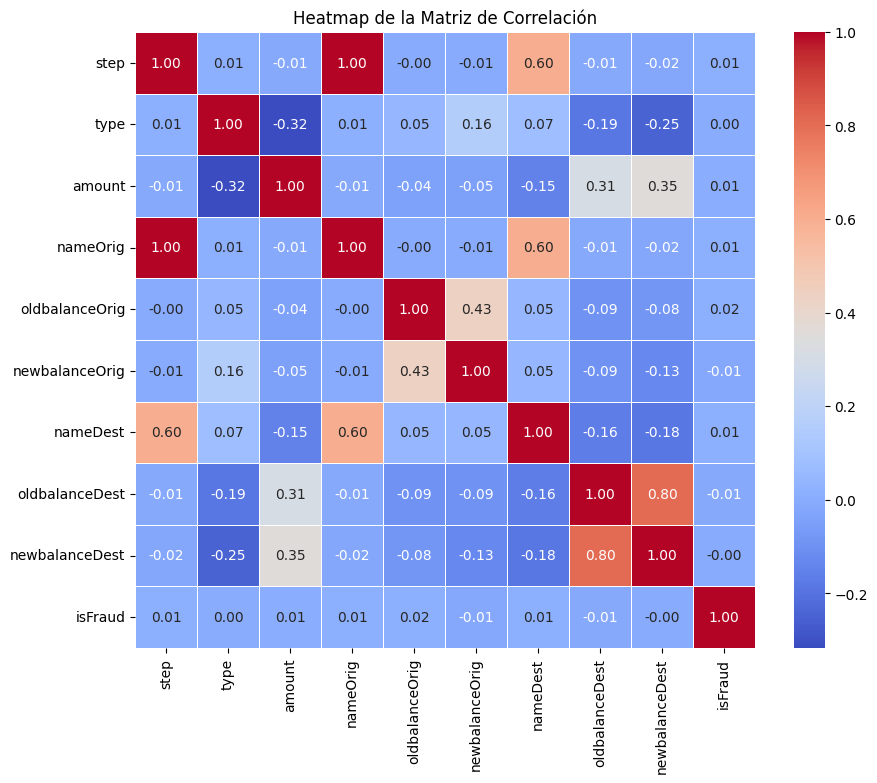

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap de la Matriz de Correlación')
plt.show()

Variables a eliminar por alta correlación: {'nameOrig'}


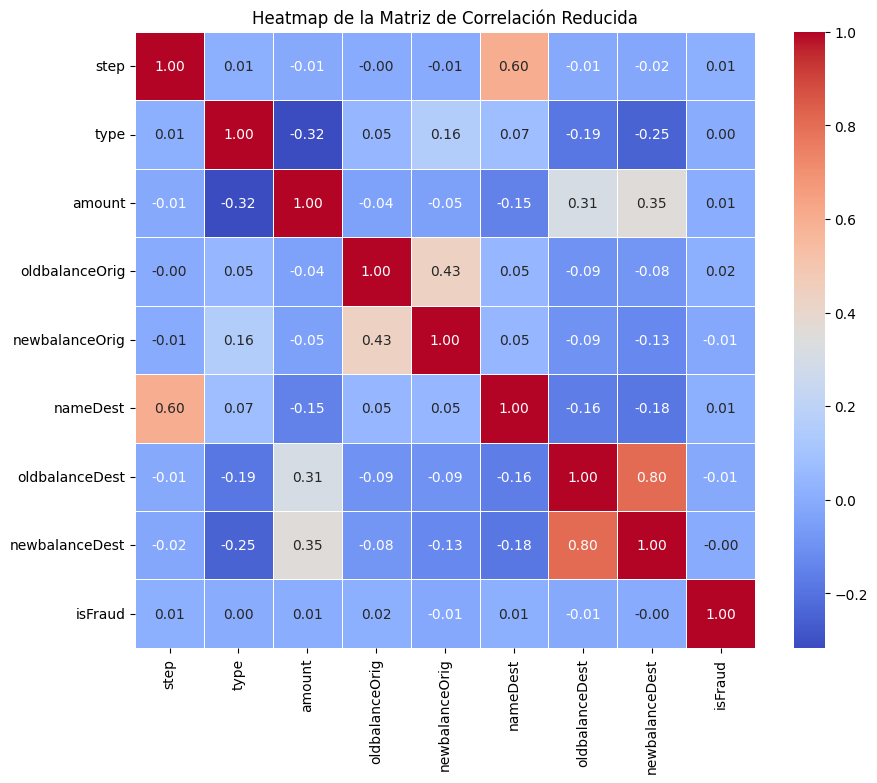

In [21]:
# Eliminar variables altamente correlacionadas
# Establecer el umbral de correlación
umbral = 0.9

# Encontrar las parejas de variables con alta correlación
correlacion_alta = [(col1, col2) for col1 in correlacion.columns for col2 in correlacion.columns 
                    if col1 != col2 and abs(correlacion.loc[col1, col2]) > umbral]

# Crear una lista de variables a eliminar
variables_a_eliminar = set()
for col1, col2 in correlacion_alta:
    if col1 not in variables_a_eliminar and col2 not in variables_a_eliminar:
        variables_a_eliminar.add(col2)

print(f"Variables a eliminar por alta correlación: {variables_a_eliminar}")

# Eliminar las variables del dataframe
df_reducido = df_encoded.drop(columns=variables_a_eliminar)

# Calcular y mostrar el nuevo heatmap de la matriz de correlación reducida
correlacion_reducida = df_reducido.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion_reducida, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap de la Matriz de Correlación Reducida')
plt.show()

In [22]:
df_reducido.to_parquet('../data/processed/df_final.parquet', engine= 'fastparquet')